<a href="https://colab.research.google.com/github/NateshReddy/Denoising-Algorithm-Implementation-/blob/master/cifar10_DNCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
batch_size = 32
num_classes = 10
epochs = 100
saveDir = "/content/drive/My Drive/denoising task/model2_dncnn"

In [3]:
(train_data_clean, _), (test_data_clean, _) = cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [4]:
train_data_clean = train_data_clean.astype('float32') / 255.
test_data_clean = test_data_clean.astype('float32') / 255.

In [5]:
def add_noise_and_clip_data(data):
   noise = np.random.normal(loc=0.0, scale=0.1, size=data.shape)
   data = data + noise
   data = np.clip(data, 0., 1.)
   return data
train_data_noisy = add_noise_and_clip_data(train_data_clean)
test_data_noisy = add_noise_and_clip_data(test_data_clean)

In [6]:
def showOrigDec(orig, noise, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display noisy
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(noise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.figtext(0.5,0.95, "ORIGINAL IMAGES", ha="center", va="top", fontsize=14, color="g")
    plt.figtext(0.5,0.5, "NOISY IMAGES", ha="center", va="top", fontsize=14, color="g")
    plt.subplots_adjust(hspace = 0.3 )
    plt.show()

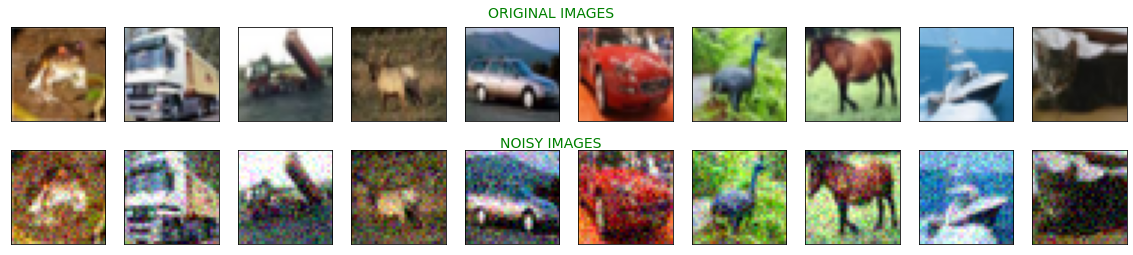

In [7]:
showOrigDec(train_data_clean, train_data_noisy)

In [8]:
input_img = Input(shape=(32, 32, 3))
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = Activation('relu')(x)

for i in range(15):
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

x = Conv2D(3, (3, 3), padding='same')(x)
output_img = Activation('tanh')(x)

In [9]:
model = Model(input_img, output_img)
model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
chkpt = saveDir + 'AutoEncoder_Cifar10_dncnn_weights.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [19]:
history = model.fit(train_data_noisy, train_data_clean,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(test_data_noisy, test_data_clean),
                    callbacks=[es_cb, cp_cb],
                    shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 161s 3ms/step - loss: 0.0020 - val_loss: 0.0020

Epoch 00001: val_loss improved from 0.00209 to 0.00195, saving model to /content/drive/My Drive/denoising task/model2_dncnnAutoEncoder_Cifar10_dncnn_weights.01-0.00-0.00.hdf5
Epoch 2/100
50000/50000 [==============================] - 161s 3ms/step - loss: 0.0019 - val_loss: 0.0023

Epoch 00002: val_loss did not improve from 0.00195
Epoch 3/100
50000/50000 [==============================] - 160s 3ms/step - loss: 0.0018 - val_loss: 0.0021

Epoch 00003: val_loss did not improve from 0.00195
Epoch 00003: early stopping


In [12]:
dae = load_model('/content/drive/My Drive/denoising task/model2_dncnn/model2_dncnnAutoEncoder_Cifar10_dncnn_weights.05-0.00-0.00.hdf5')

In [20]:
test_data_denoised = dae.predict(test_data_noisy)

In [21]:
score = dae.evaluate(test_data_noisy, test_data_clean, verbose=1)
print(score)

10000/10000 [==============================] - 8s 810us/step
0.002090626859292388


In [14]:
# definition to show original image and reconstructed image
def showOrigDec(orig, noise, denoise, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 6))

    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display noisy image
        ax = plt.subplot(3, n, i +1 + n)
        plt.imshow(noise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display denoised image
        ax = plt.subplot(3, n, i +1 + n + n)
        plt.imshow(denoise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.figtext(0.5,0.95, "ORIGINAL IMAGES", ha="center", va="top", fontsize=14, color="g")
    plt.figtext(0.5,0.65, "NOISY IMAGES", ha="center", va="top", fontsize=14, color="g")
    plt.figtext(0.5,0.35, " DENOISED RECONSTRUCTED IMAGES", ha="center", va="top", fontsize=14, color="g")
    plt.subplots_adjust(hspace = 0.5 )
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


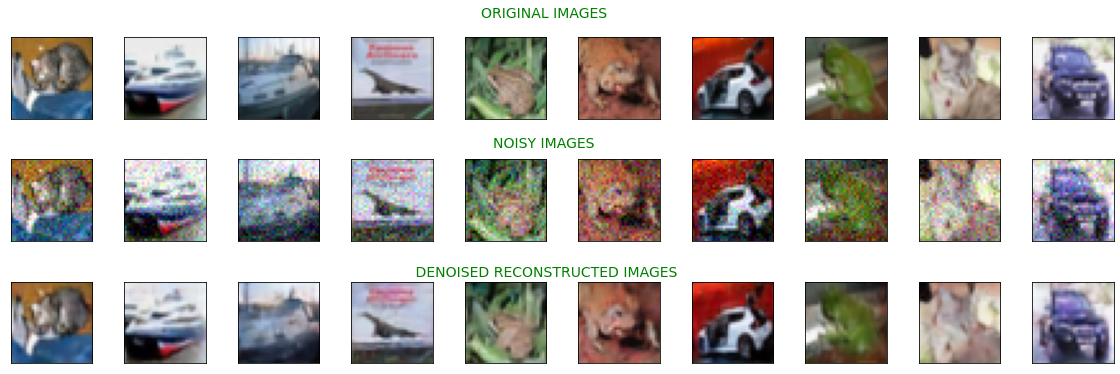

In [17]:
showOrigDec(test_data_clean, test_data_noisy, test_data_denoised)

In [22]:
def mse(data_1, data_2):
   return np.square(np.subtract(data_1, data_2)).mean()

noisy_clean_mse = mse(test_data_clean, test_data_noisy)
denoised_clean_mse = mse(test_data_denoised, test_data_clean)

noisy_clean_mse, denoised_clean_mse

(0.00930411339533389, 0.00209063)

In [24]:
from skimage import metrics
avg_psnr = metrics.peak_signal_noise_ratio(test_data_clean,test_data_denoised)
avg_psnr

26.797234733695316

In [25]:
avg_ssim = metrics.structural_similarity(test_data_clean,test_data_denoised,multichannel=True)
avg_ssim

0.9801776409746298